In [ ]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    


In [ ]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/Assignment/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/Assignment/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/Assignment/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

In [ ]:
df_train

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [ ]:
# df_train[df_train['Emotion'] == 'love']['Text']

In [ ]:
# yuhu = df_train.loc[(df_train['Emotion'] == 'love')]

In [ ]:
# yuhu.index

In [ ]:
# df_train.iloc[(yuhu.index[2])]

In [ ]:
# from textaugment import Wordnet

# t = Wordnet()
# # text = X_train[0]
# # print(dftext)
# text = []
# for i in yuhu.index:
#     y = t.augment(df_train.iloc[(i)]['Text'])
#     text.append(y)

In [ ]:
# text[4], df_train.iloc[yuhu.index[4]]['Text']

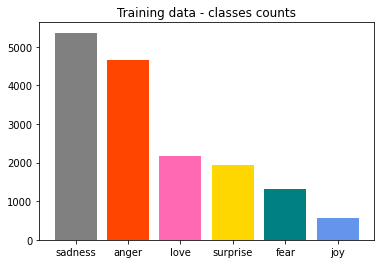

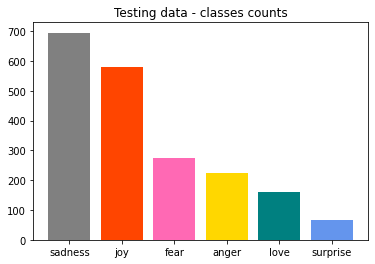

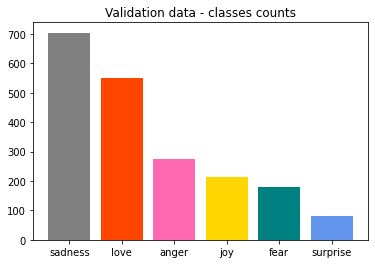

In [ ]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(list(y_train.unique()), y_train.value_counts(),color = colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(list(y_test.unique()), y_test.value_counts(),color = colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(list(y_val.unique()), y_val.value_counts(),color = colors)
plt.title("Validation data - classes counts")
plt.show()

In [ ]:
# Encode labels
# Sudah disediakan beberapa variable, lengkapi variabel tersebut
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

# y_train = 
# y_test = 
# y_val = 

In [ ]:
y_train

array([4, 4, 0, ..., 2, 0, 4])

In [ ]:
unique, counts = np.unique(y_train, return_counts = True)
print(dict(zip(unique, counts)))

{0: 2159, 1: 1937, 2: 5362, 3: 1304, 4: 4666, 5: 572}


In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [ ]:
len(X_train)

16000

In [ ]:
#Read GloVE embeddings
path_to_glove_file = '/content/drive/MyDrive/Assignment/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [ ]:
embedding_matrix.shape[0]

16185

In [ ]:
# Build neural network architecture
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],input_length = 256,weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(64,dropout=0.6, return_sequences = True )))
model.add(Bidirectional(LSTM(32,dropout=0.6, return_sequences = False )))
# model.add(LSTM(1024, return_sequences=False))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.6))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.6))
model.add(Dense(6, activation = 'softmax'))
adam = Adam(learning_rate=0.005)
#code here
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 256, 200)          3237000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 256, 128)         135680    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                

In [ ]:
from keras.callbacks import EarlyStopping , ModelCheckpoint, ReduceLROnPlateau

In [ ]:
#Callback
model_save = ModelCheckpoint('./yuhu.h5', save_best_only = True, save_weights_only = True, monitor = 'val_accuracy',
                             mode = 'auto', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.001, patience = 7, mode = 'max',
                           verbose = 1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.75, patience = 2, min_delta=0.01,verbose =1, mode ='min' )
# callback = EarlyStopping(
#     #code here (contains at least : monitor, patience, restore_best_weights)
# )

In [ ]:
# Fit model
history = model.fit(X_train, y_train,batch_size = 64, validation_data=[X_val, y_val], epochs = 100, callbacks = [model_save, early_stop, reduce_lr])
# code here

Epoch 1/100
249/250 [============================>.] - ETA: 0s - loss: 1.1316 - accuracy: 0.5649
Epoch 1: val_accuracy improved from -inf to 0.77700, saving model to ./yuhu.h5
250/250 [==============================] - 18s 52ms/step - loss: 1.1294 - accuracy: 0.5658 - val_loss: 0.4766 - val_accuracy: 0.7770 - lr: 0.0050
Epoch 2/100
249/250 [============================>.] - ETA: 0s - loss: 0.3877 - accuracy: 0.8439
Epoch 2: val_accuracy improved from 0.77700 to 0.91100, saving model to ./yuhu.h5
250/250 [==============================] - 12s 46ms/step - loss: 0.3868 - accuracy: 0.8443 - val_loss: 0.2025 - val_accuracy: 0.9110 - lr: 0.0050
Epoch 3/100
249/250 [============================>.] - ETA: 0s - loss: 0.1996 - accuracy: 0.9299
Epoch 3: val_accuracy improved from 0.91100 to 0.93750, saving model to ./yuhu.h5
250/250 [==============================] - 11s 46ms/step - loss: 0.1996 - accuracy: 0.9299 - val_loss: 0.1472 - val_accuracy: 0.9375 - lr: 0.0050
Epoch 4/100
250/250 [=======

In [ ]:
y_train.shape

(16000, 6)

In [ ]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 1s 20ms/step - loss: 0.1446 - accuracy: 0.9400


[0.144578754901886, 0.9399999976158142]

In [ ]:
y_pred = model.predict(X_val)

In [ ]:
import tensorflow as tf

In [ ]:
y_val = tf.argmax(y_val, axis = 1)
y_pred = tf.argmax(y_pred, axis = 1)

In [ ]:
y_pred, y_val

(<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 3, ..., 2, 3, 2])>,
 <tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 3, ..., 2, 2, 2])>)

In [ ]:
y = np.array([0,1,2,3,4,5])
le.inverse_transform(y)

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [ ]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr
target_names = ['anger', 'fear', 'joy','love','sadness', 'surprise']
print(cr(y_pred, y_val, target_names = target_names))

              precision    recall  f1-score   support

       anger       0.92      0.95      0.93       266
        fear       0.84      0.92      0.88       194
         joy       0.95      0.97      0.96       696
        love       0.90      0.89      0.89       180
     sadness       0.98      0.96      0.97       564
    surprise       0.95      0.77      0.85       100

    accuracy                           0.94      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.94      0.94      0.94      2000



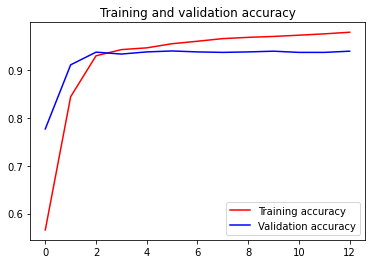

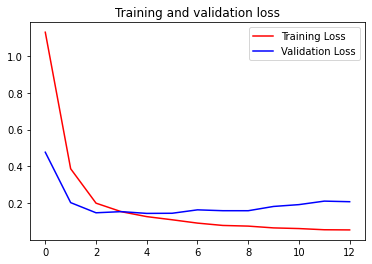

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Classify custom sample

sentences = [
            'i want each of you to feel my gentle embrace'
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n")

i want each of you to feel my gentle embrace
love : 0.9997747540473938



In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Recognition.h5')